<a href="https://colab.research.google.com/github/CastHash532/kaggle-automl/blob/main/Kaggle_sentiment_NLP_fast_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install fast-bert

     |████████████████████████████████| 99 kB 5.8 MB/s 
     |████████████████████████████████| 124 kB 44.4 MB/s 
     |████████████████████████████████| 769 kB 52.3 MB/s 
     |████████████████████████████████| 3.0 MB 40.5 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 34.6 MB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=bbedc73ad6f61be0266dafc87e1a255fdf78c869ea02d7be5cdd80992e2ff87a
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


## Load data and preprocess



In [19]:
!kaggle datasets download -d kritanjalijain/amazon-reviews

 99% 1.29G/1.29G [00:23<00:00, 59.5MB/s]
100% 1.29G/1.29G [00:23<00:00, 58.4MB/s]


In [20]:
!ls

 amazon-reviews.zip  'sentiment labelled sentences'
 sample_data	      sentiment-labelled-sentences-data-set.zip


In [21]:
!unzip -u amazon-reviews.zip

Archive:  amazon-reviews.zip
  inflating: amazon_review_polarity_csv.tgz  
  inflating: test.csv                
  inflating: train.csv               


In [53]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('/content/train.csv', names=['label','text','add'])

In [54]:
dataset= dataset[0:1000]

In [ ]:
dataset

In [56]:
dataset['text'] = dataset['text'] + [' '] + dataset['add']
dataset.drop(['add'],axis=1,inplace=True)

In [58]:
dataset['label'] = dataset['label'].map(lambda x: 0 if x == 1 else 1)

In [61]:
from sklearn.model_selection import train_test_split

ds_train, ds_test = train_test_split(dataset,test_size=0.2, random_state=42)


In [62]:
text= 'text'
target='label'

In [ ]:
# Take a subset of the News dataset and save it to csv files
ds_train.to_csv('/content/dtrain.csv')
ds_test.to_csv('/content/dtest.csv')

In [74]:
labels = [0,1]
pd.DataFrame(labels).to_csv('/content/labels.csv', index=False, header=False)

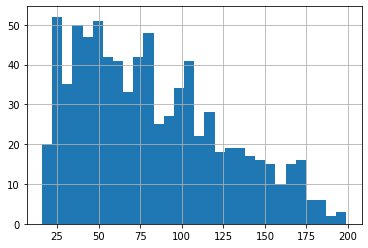

In [70]:
seq_len = [len(i.split()) for i in ds_train['text']]

pd.Series(seq_len).hist(bins = 30)

## Defining Model

In [75]:
from fast_bert.data_cls import BertDataBunch
import torch

DATA_PATH = LABEL_PATH = OUTPUT_PATH ='/content'

databunch = BertDataBunch(DATA_PATH, LABEL_PATH,
                          tokenizer='bert-base-uncased',
                          train_file='dtrain.csv',
                          val_file='dtest.csv',
                          label_file='labels.csv',
                          text_col=text,
                          label_col=target,
                          batch_size_per_gpu=64,
                          max_seq_length=256,
                          multi_gpu=True if torch.cuda.device_count() > 1 else False,
                          multi_label=False,
                          model_type='bert')

In [76]:

from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging


logger = logging.getLogger()
device_cuda = torch.device("cuda")
metrics = [{'name': 'accuracy', 'function': accuracy}]

learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir=OUTPUT_PATH,
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True if torch.cuda.device_count() > 1 else False,
						is_fp16=True,
						multi_label=False,
						logging_steps=50,
						freeze_transformer_layers=True
						)


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Fine Tuning and Validation

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lamb/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


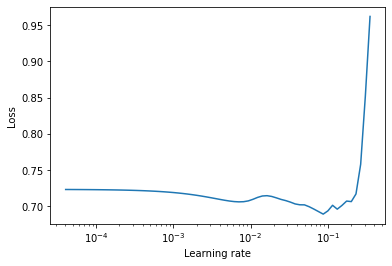

In [77]:
#learner.lr_find(start_lr=1e-5,optimizer_type='lamb')

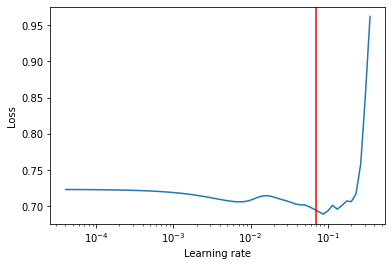

In [80]:
#learner.plot(show_lr=7e-2)

In [81]:
#fine tuning the model
learner.fit(epochs=3,
			lr=7e-2,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="lamb")


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:247: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


(39, 0.7220907944899339)

In [82]:
learner.validate()

{'accuracy': 0.605, 'loss': 0.6790350377559662}